# Overview

  - A: Introduction
  - B: Parts of quantumsim
  - C: Math
  - D: Application 1: Creation of a Bell state
  - E: Application 2: Repeated measurements

# A: Introduction

In [175]:
import quantumsim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Goal of *quantumsim*
  - Simulate the result of running quantum circuits on experimental imperfect hardware
  - Description should be compatible with descriptions used by experimentalists
  - Fast enough for investigating quantum error correction on Surface-17

## What *quantumsim* does

  - Calculate the density matrix of a composite quantum system (qubits) after applying local (1 and 2 qubit) processes
  - Processes are described by process matrices
    - from models with experimental parameters (e.g. $T_1, T_2$ amplitude-phase damping)
    - integrating master equations (not part of *quantumsim*, but there is *qutip*)
    - from experiment directly (process tomography)
  - Measurements: Allow also probabilistic projections, e. g. measurements. Then obtain conditional density matrix.
  
  - The calculations are performed on a GPU
  - Python 3
  - Open source (GPL), get on https://gitlab.com/quantumsim/quantumsim

## Status of quantumsim

  - "Old quantumsim" (master branch)
    - Quite stable, used by several people and in a handful of publications.
    - Achieved the goal: "Density-matrix simulation of small surface codes under current and projected experimental noise" (npj Quant. Inf. 3, 39 (2017))
    - Inflexible internal representation: Restricted to qubits as subsystems and a fixed *Pauli basis*.
  - "New quantumsim"
    - Wanted to include leakage (non-computational states)
    - Almost completely rewritten for flexible internal representation
    - Slightly slower on GPU (about 50% - 75%)
    - New optimization: automated basis choice
    - But: Frontend not finished, essentially only usable by the author
  
Focus on "old quantumsim". I'll point out the differences.

## B: Parts of quantumsim

### 1. A library of process matrices (aka Pauli transfer matrices)

In [ ]:
import quantumsim.ptm as ptm

### 2. Two density matrix backends
  - `dm10` running on Nvidia GPU, written in CUDA C (https://developer.nvidia.com/cuda-zone) 
  - `dm_np` with `numpy`.

In [176]:
# usually you do not need this, use quantumsim.sparse_dm

# my laptop has no Nvidia GPU :(
import quantumsim.dm_np as dm 

### 3. A wrapper for the backends

`sparsedm` gives a more usable interface to the backend, for instance
  - keeps track of qubits in classical states (no need to represent in density matrix)
  - Manages a mapping between qubit names and indices in density matrix
  - When you load `sparse_dm` it selects the GPU backend if available, otherwise uses `numpy` backend
  
The first big player: The `sparse_dm.SparseDM` object. 

It represents the quantum state of a system, processes can be applied to it, and the density matrix (or parts) can be extracted.

In [ ]:
import quantumsim.sparsedm as sparsedm

In [ ]:
sparsedm.using_gpu

### 4. A helper to collect and sort process matrices

`circuit` module makes it easy to build a circuit (and plot it before running).
Essentially, it just maintains a list of process matrices.

  - Automatic insertion of idling gates
  - Contains certain optimization routines that are very useful for large systems (Surface-17)
  
The second big player: The `circuit.Circuit` object and the `circuit.Gate` objects.

In [ ]:
import quantumsim.circuit as circuit

## C: Math

### Density matrix

A quantum system is described by a density matrix

$$ \rho_{x, x'}$$ 

$x$ and $x'$ go over all states of the system.

When the system consists of subsystems, each state is described by a multiindex, e.g. for two qubits:

$$ \rho_{xy, x'y'} $$

$x, y, x', y'$ are 0 or 1.


The density matrix is complex and Hermitian. A $n \times n$ density matrix thus has $n^2$ *real* degrees of freedom.


### Pauli vectors

Every density matrix for qubits can be expanded in the Pauli basis:

$$ \rho_{xy, x'y'} = \sum_{a, b} P_{ab} \sigma_{xx'}^{(a)} \otimes \sigma_{yy'}^{(b)}$$

Backwards formula:

$$ P_{ab} = \mathrm{Tr} \left( \rho (\sigma^{(a)} \otimes \sigma^{(b)})\right)$$

$a$ and $b$ are $0, x, y, z$. 

The numbers $P_{ab}$ with one multi-index are called the Pauli vector.
(The density *matrix* has two multi-indices)

The backwards formula requires orthonormality:
$$ \mathrm{Tr} (\sigma^{(a)} \sigma^{(b)}) = \delta_{ab}$$

This is *not* true for the usual Pauli matrices, they have to be normalized (divide by $\sqrt{2}$).

### Another basis

Instead of using the normal Pauli matrices, quantumsim uses a slightly different basis:

$\sigma^{(0)} = \begin{pmatrix} 1 & 0 \\ 0 & 0\end{pmatrix}$

$\sigma^{(x)} = \frac{1}{\sqrt{2}} \begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix}$

$\sigma^{(y)} = \frac{1}{\sqrt{2}} \begin{pmatrix} 0 & -i \\ i & 0\end{pmatrix}$

$\sigma^{(1)} = \begin{pmatrix} 0 & 0 \\ 0 & 1\end{pmatrix}$,

$a, b$ then are $0, x, y, 1$.

This basis is also orthonormal. It has the advantage that the distribution of measurement outcomes - diagonal of the density matrix - can be extracted easier.

"Old quantumsim" always uses this basis. The major development of "new quantumsim" is that the basis can be chosen arbitrary:
  - any dimension (for instance the nine Gell-Mann matrices for qutrits),
  - different for different subsystems (some qubits, some qutrits),
  - can even be incomplete, if that is enough to describe the system

### Processes

Processes on density matrices are described by linear "superoperators".

Since we demoted matrices $\rho_{xy, x'y'}$ to vectors $P_{ab}$, processes are then just matrices. Quantumsim supports one- (4x4) and two-qubit (16x16) processes.

Let's look at a few in the `ptm` module.

In [ ]:
X90 = ptm.rotate_x_ptm(angle=np.pi/2)

print(X90.round(3))

In [221]:
# See Nielsen-Chuang. 
# gamma is the decay probability, γ = 1-exp(-t/T1),
# lamda characterizes phase damping, λ = 1-exp(-t/Tφ)

decay = ptm.amp_ph_damping_ptm(gamma=0.01, lamda=0.0)

print(decay.round(3))

[[ 1.     0.     0.     0.01 ]
 [ 0.     0.995  0.     0.   ]
 [ 0.     0.     0.995  0.   ]
 [ 0.     0.     0.     0.99 ]]


In [222]:
# You can build your own PTMs from Kraus operators. 
# For instance, a phase flip with 10% probability:

p = 0.1

kraus_phase_flip = np.sqrt(p) * np.c_[[1, 0], [0, -1]]
kraus_no_phase_flip = np.sqrt(1-p) * np.c_[[1, 0], [0, 1]]

In [223]:
phase_flip_ptm = ptm.single_kraus_to_ptm(kraus_phase_flip) + \
                 ptm.single_kraus_to_ptm(kraus_no_phase_flip)

In [224]:
print(phase_flip_ptm)

[[ 1.   0.   0.   0. ]
 [ 0.   0.8  0.   0. ]
 [ 0.   0.   0.8  0. ]
 [ 0.   0.   0.   1. ]]


In [225]:
# This is of course a special case of phase damping:
# (See nielson and chuang p. 385)
phase_flip_ptm2 = ptm.amp_ph_damping_ptm(gamma=0.0, lamda=1-(1-2*p)**2)
print(phase_flip_ptm2)

[[ 1.   0.   0.   0. ]
 [ 0.   0.8  0.   0. ]
 [ 0.   0.   0.8  0. ]
 [ 0.   0.   0.   1. ]]


### Example 1: Excite a qubit

Adriaan has a system with two qubits. He tries to excite one qubit to the 1 state using two perfect X90 gates, but has some decay inbetween and after.

In [226]:
# initialize a system with two qubits, named "QL" and "QR"

state = sparsedm.SparseDM(["QL", "QR"])

In [227]:
# newly created systems are initialized in the ground state

# this very useful function extracts the measurement outcome distribution
state.peak_multiple_measurements(bits=["QL", "QR"])

[({'QL': 0, 'QR': 0}, 1.0)]

In [228]:
# Adriaan does his thing:

state.apply_ptm("QL", decay)
state.apply_ptm("QR", decay)

state.apply_ptm("QL", X90)

state.apply_ptm("QL", decay)
state.apply_ptm("QR", decay)

state.apply_ptm("QL", X90)

state.apply_ptm("QL", decay)
state.apply_ptm("QR", decay)


In [230]:
state.peak_multiple_measurements(bits=["QL", "QR"])

[({'QL': 0, 'QR': 0}, 0.012481218632222679),
 ({'QL': 1, 'QR': 0}, 0.98751878136777727),
 ({'QL': 0, 'QR': 1}, 0.0),
 ({'QL': 1, 'QR': 1}, 0.0)]

We can get the full density matrix:

In [231]:
rho = state.full_dm.to_array()
print(rho.round(3))

[[ 0.012+0.j     0.000+0.005j  0.000+0.j     0.000+0.j   ]
 [ 0.000-0.005j  0.988+0.j     0.000+0.j     0.000+0.j   ]
 [ 0.000+0.j     0.000+0.j     0.000+0.j     0.000+0.j   ]
 [ 0.000+0.j     0.000+0.j     0.000+0.j     0.000+0.j   ]]


The qubit are mapping is accessible here (0 is least-significant):

In [232]:
state.idx_in_full_dm

{'QL': 0, 'QR': 1}

## A closer look at `sparse_dm`

Let's have a closer look at:

#### Classical qubits

 - Qubits that are in a definite state (0 or 1) and not entangled with the rest of the system are called 'classical'
 - Classical qubits are not represented in the density matrix
 
#### PTM compilation

 - PTM's are not applied immediately
 - This way, when several consecutive PTM's are applied to the same qubit, they can be combined to one before applying
 - Reduces number of operations on the large Pauli vector

In [233]:
# In the beginning, all qubits are in the ground state, thus classical
state = sparsedm.SparseDM(["QL", "QR"])

In [234]:
# both qubits have classical state 0
state.classical

{'QL': 0, 'QR': 0}

In [235]:
# no qubits are in the density matrix
state.idx_in_full_dm

{}

In [236]:
# the density matrix is just the 1 x 1 unit matrix
state.full_dm.to_array()

array([[ 1.]])

In [237]:
# applying a ptm to a classical bit should add it to the density matrix
state.apply_ptm("QL", X90)

In [240]:
# but it's still classical and 0!?
state.classical

{'QL': 0, 'QR': 0}

In [241]:
state.idx_in_full_dm

{}

In [242]:
# the PTM has not applied yet! it is held back for PTM compilation

# We enforce the computation:
state.apply_all_pending()

In [243]:
# now the computation has been performed
state.classical

{'QR': 0}

In [244]:
state.idx_in_full_dm

{'QL': 0}

In [246]:
# this is the density matrix of QL only, QR is still classical
print(state.full_dm.to_array().round(3))

[[ 0.5+0.j   0.0+0.5j]
 [ 0.0-0.5j  0.5+0.j ]]


### Example 2: Make a Bell state

Adriaan now also has a perfect C-Phase gate. He wants to make the Bell state $|01\rangle + |10\rangle$ by 
  - start from the ground state
  - X90 on both qubits
  - C-Phase
  - X90 on QL
  
Let's see whether in the absence of decay, this works out.

In [ ]:
# We need the PTM for cphase gate. First make the unitary:

cphase_unitary = np.diag([1, 1, 1, -1])

In [ ]:
print(cphase_unitary)

In [247]:
# then convert it to a 16x16 two-qubit PTM
cphase_ptm = ptm.double_kraus_to_ptm(cphase_unitary)

In [248]:
print(cphase_ptm)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. 

In [279]:
# Now we can make a bell state
def make_bell_state():
    # Make system in the ground state
    bell_state = sparsedm.SparseDM(["QL", "QR"])
    
    # Apply the processes
    bell_state.apply_ptm("QL", X90)
    bell_state.apply_ptm("QR", X90)
    bell_state.apply_two_ptm("QL", "QR", cphase_ptm)
    bell_state.apply_ptm("QL", X90)

    # Enforce calculation
    bell_state.apply_all_pending()
    
    return bell_state

In [280]:
bell = make_bell_state()

Let's visualize the result using qutip:

(<matplotlib.figure.Figure at 0x7f5d740e0898>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f5d73fbccc0>)

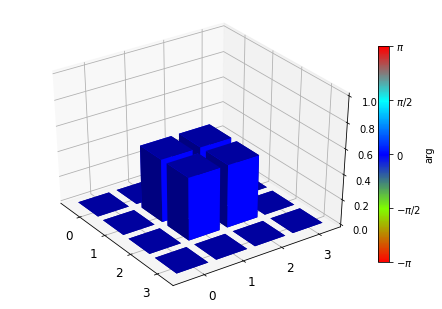

In [281]:
import qutip
rho = bell.full_dm.to_array()
qutip.matrix_histogram_complex(rho)

And the measurement outcomes are indeed "01" and "10" with 1/2 probability:

In [282]:
bell.peak_multiple_measurements(["QL", "QR"])

[({'QL': 0, 'QR': 0}, -5.5511151231257827e-17),
 ({'QL': 1, 'QR': 0}, 0.50000000000000011),
 ({'QL': 0, 'QR': 1}, 0.5),
 ({'QL': 1, 'QR': 1}, -1.1102230246251565e-16)]

## Measurements

The effect of a measurements is just projection to a definite state:
  - that qubit becomes classical and is removed from the density matrix
  - the density matrix has no longer trace 1. It's trace is the probability for the projected measurement outcome.

In [283]:
# make another perfect bell state
bell = make_bell_state()

# Let's say QL is measured and outcome is 1
bell.project_measurement("QL", 1)

In [284]:
# now QL is classical
bell.classical

{'QL': 1}

In [285]:
# QR is still in the density matrix
bell.idx_in_full_dm

{'QR': 0}

In [286]:
# the density matrix now has trace 0.5,
# which is the probability that QL is indeed measured as 1
bell.full_dm.to_array()

array([[  5.00000000e-01+0.j,   0.00000000e+00+0.j],
       [  0.00000000e+00+0.j,  -1.11022302e-16+0.j]])

In [287]:
# We can also get the trace like this
bell.trace()

0.5

In [288]:
# We can renormalize to get the conditional density matrix
bell.renormalize()

In [289]:
bell.full_dm.to_array()

array([[  1.00000000e+00+0.j,   0.00000000e+00+0.j],
       [  0.00000000e+00+0.j,  -2.22044605e-16+0.j]])

In [290]:
# Indeed, since the qubits were entangled, QL is now 1 and QR is now 0
bell.peak_multiple_measurements(["QL", "QR"])

[({'QL': 1, 'QR': 0}, 1.0000000000000002),
 ({'QL': 1, 'QR': 1}, -2.2204460492503131e-16)]

## Everything easier: Circuit

  - Writing larger circuits in the manner above becomes tedious
  - Especially when decay processes have to be inserted
  
The `Circuit` class helps. Now you specify:
  - the qubits with decay parameters (T1, T2*)
  - the gates and their times
  - a sampler that determines how measurement outcomes are selected:
    - fixed outcome, as above
    - randomly selected according to Born's rule

Then the decay PTMs are inserted automatically, the circuit can be plotted, and finally applied to a `SparseDM`.

Note: The basic assumption here is that realistic gates can be approximated by "sandwiching" perfect gates with idling processes.

### Example: Bell state preparation again with circuits


In [291]:
# Make a circuit, give it a name

c = circuit.Circuit("Bell state preparation");

In [292]:
# Specify the qubits. Time unit is arbitrary, I usually use nanoseconds.

ql = circuit.Qubit("QL", t1=7000, t2=4000) # quite bad qubits
qr = circuit.Qubit("QR", t1=3000, t2=5000)

c.add_qubit(ql)
c.add_qubit(qr);

In [293]:
# Specify the gates
# Let's say: 
# single qubit gate takes 20 ns
# two-qubit gate takes 100 ns

# circuit module contains quite a selection of gates:

g = circuit.RotateX("QL", time=10, angle=np.pi/2)
c.add_gate(g)

g = circuit.RotateX("QR", time=10, angle=np.pi/2)
c.add_gate(g)

g = circuit.CPhase("QL", "QR", time=70)
c.add_gate(g)

g = circuit.RotateX("QL", time=130, angle=np.pi/2)
c.add_gate(g);

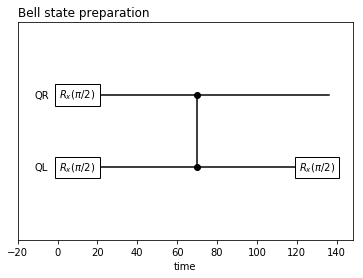

In [294]:
c.plot();

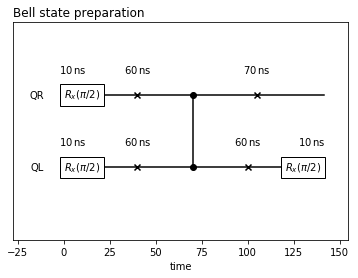

In [295]:
# add the decay processes
c.add_waiting_gates(tmin=0, tmax=140)
c.plot();

In [296]:
# finalize the circuit by bringing the gate list to temporal order
# very important!!!

c.order()


In [297]:
# and now make a SparseDM and apply the circuit to it

bell2 = sparsedm.SparseDM(c.get_qubit_names())

In [298]:
c.apply_to(bell2, apply_all_pending=True)

Let's see what we get

In [299]:
bell2.peak_multiple_measurements(c.get_qubit_names())

[({'QL': 0, 'QR': 0}, 0.019388548342828354),
 ({'QL': 1, 'QR': 0}, 0.50181538191630748),
 ({'QL': 0, 'QR': 1}, 0.47173088887905273),
 ({'QL': 1, 'QR': 1}, 0.0070651808618114043)]

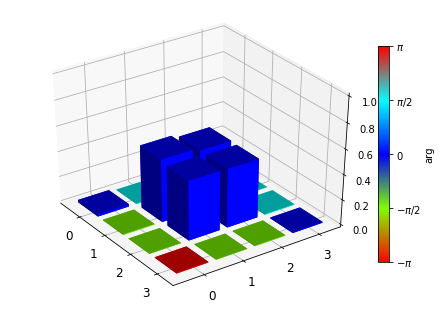

In [300]:
rho2 = bell2.full_dm.to_array()
qutip.matrix_histogram_complex(rho2);

In [301]:
qutip.fidelity(qutip.Qobj(rho), qutip.Qobj(rho2))

0.9815738501287656

## Example 3: Repeated indirect measurements

Niels performs repeated indirect measurements of QL using QR as an ancilla.

Starting from the ground state, repeat:
  - CNOT from QL on QR
  - measure QR
  - flip QL
  
If everything works perfectly, we expect 0, 1, 1, 0, 0, 1, 1... measurement outcomes, since

  - QL is 0, 1, 0, 1, 0 ...
  - QR is flipped if QL is 1: every second round.

In [303]:
# make circuit
c = circuit.Circuit("Indirect measurement round")

# add the qubits
ql = circuit.Qubit("QL", t1=10000, t2=10000)
qr = circuit.Qubit("QR", t1=10000, t2=10000)

c.add_qubit(ql)
c.add_qubit(qr);

# CNOT using CPHASE and two Y rotations:
g = circuit.RotateY("QR", time=10, angle=np.pi/2)
c.add_gate(g)

g = circuit.CPhase("QL", "QR", time=70)
c.add_gate(g)

g = circuit.RotateY("QR", time=130, angle=-np.pi/2)
c.add_gate(g)

# flip QL

g = circuit.RotateX("QL", time=130, angle=np.pi)
c.add_gate(g);

# measurement:

# 1. we need another bit to hold the measurement outcome
# "classical bits" are just qubits that have no decay channel
mqr = circuit.ClassicalBit("mQR")
c.add_qubit(mqr)

# 2. we need a "sampler" that determines how outcomes are chosen
# This sampler selects randomly using Born's rule
# The measurement outcome is reported wrong with 1.5% probability
sampler = circuit.BiasedSampler(readout_error=0.015, seed=42, alpha=1)

# 3. insert the measurement operation
# Let's say the measurement takes 1000 ns
g = circuit.Measurement("QR", output_bit="mQR", 
                        time=140+500, sampler=sampler)
c.add_gate(g)

# finalize
c.add_waiting_gates(0, 1140)
c.order()

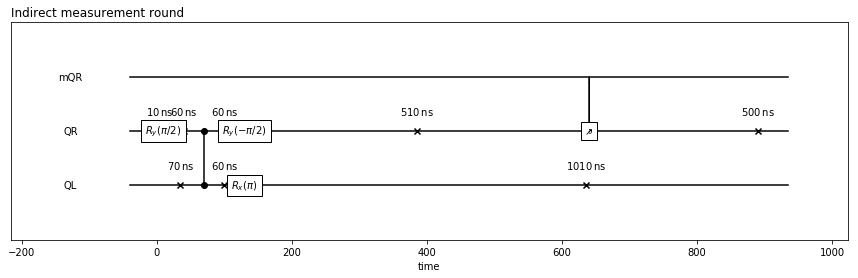

In [304]:
fig, ax = c.plot();
fig.set_figwidth(15)

Now make a `SparseDM` and run 80 rounds, saving `mQR` after every round.

In [305]:
state = sparsedm.SparseDM(c.get_qubit_names())

results = []

for i in range(80):
    c.apply_to(state)
    results.append(state.classical["mQR"])    

We mostly get the expected pattern:

In [306]:
print(results)

[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]


We can analyze the data by looking at "events", where $mQL(t) \not= mQL(t-2)$

In [307]:
events = [0, 0] + [1 - x ^ y for x, y in zip(results, results[2:])]

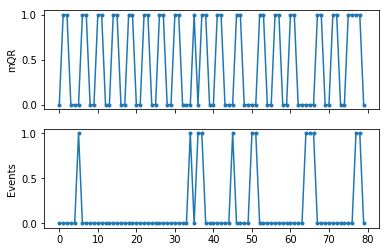

In [308]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(results, ".-")
ax1.set_ylabel("mQR")

ax2.plot(events, ".-")
ax2.set_ylabel("Events");


In [309]:
# The probability to obtain exactly this pattern is quite low, of course
state.trace()

4.6536437630655404e-13

# The End. Thank you.